# Healthcare Fraud Detection – Data Prep & Modeling  
_Map of what’s inside this notebook_

**Feature Engineering**  
- [Outpatient features](#outpatient-features)  
- [Inpatient features](#inpatient-features)  
- [Merge and finalize dataframe](#merge-and-finalize-dataframe)

**Modeling**

- [Logistic Regression](#logistic-regression)
  - [CM and ROC-AUC for Logistic Regression](#cm-and-roc-auc-for-logistic-regression)
- [Hyperparameter Tuning Using GridSearchCV](#hyperparameter-tuning-using-gridsearchcv)
  - [CM and ROC-AUC for for GridSearchCV](#cm-and-roc-auc-for-gridsearchcv)
- [Logistic Regression with SMOTE](#logistic-regression-with-smote)
  - [CM and ROC-AUC for for LR + SMOTE](#confusion-matrix-for-lr--smote)

**Summary**
- [Summary](#summary)

In [1]:
# import libraries to be used in the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment. I have the environment set up with all the libraries you need.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
# Set the default display option for the notebook.
pd.set_option('display.max_columns', 50)

# Set a default column name format.
def clear_cols(s):
    return s.strip().replace(" ","_")

In [ ]:
# Read data files
inpatient_path   = 'MyProjects/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProjects/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProjects/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProjects/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'

# Read the CSV files and rename columns
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
4432,PRV56545,No


In [5]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
24363,BENE100471,CLM62349,2009-08-03,2009-08-05,PRV54098,7000,PHY321514,PHY321514,NaN,2009-08-03,5121,1068.0,2009-08-05,199,5128,2724,4019,7830,E8788,NaN,NaN,NaN,NaN,NaN,3404.0,NaN,NaN,NaN,NaN,NaN


In [6]:
outpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
362560,BENE114912,CLM458694,2009-07-08,2009-07-09,PRV55913,500,PHY411809,NaN,NaN,5163,25000,4240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,78605


## Outpatient features

In [7]:
# Convert dates to datetime format in Outpatient dataset.
outpatient['ClaimStartDt'] = pd.to_datetime(outpatient['ClaimStartDt'])
outpatient['ClaimEndDt'] = pd.to_datetime(outpatient['ClaimEndDt'])
outpatient['ClaimDuration'] = (outpatient['ClaimEndDt'] - outpatient['ClaimStartDt']).dt.days.astype(int)
outpatient.sample(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimDuration
252028,BENE83282,CLM613870,2009-10-04,2009-10-04,PRV55050,900,PHY354374,NaN,PHY354374,20301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
6283,BENE12796,CLM728879,2009-12-14,2009-12-14,PRV55907,100,PHY337012,NaN,PHY348866,2541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
223042,BENE75047,CLM229826,2009-03-05,2009-03-05,PRV55507,80,PHY417212,NaN,NaN,V149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
502675,BENE154787,CLM375995,2009-05-23,2009-05-23,PRV52367,20,PHY344289,NaN,NaN,8208,V5413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [8]:
outpatient['ClaimDuration'].value_counts()

ClaimDuration
0     453348
20     24312
1      11960
2       4366
14      2735
3       2597
7       2564
4       2238
5       1511
9       1378
6       1306
8       1189
16      1136
10       982
15       975
11       953
13       947
12       903
17       808
18       800
19       727
23         1
21         1
Name: count, dtype: int64

## Inpatient features

In [9]:
inpatient['Provider'].nunique()

2092

In [10]:
# Convert dates to datetime format in Inpatient
inpatient['ClaimStartDt'] = pd.to_datetime(inpatient['ClaimStartDt'])
inpatient['ClaimEndDt'] = pd.to_datetime(inpatient['ClaimEndDt'])
inpatient['ClaimDuration'] = (inpatient['ClaimEndDt'] - inpatient['ClaimStartDt']).dt.days.astype(int)
inpatient.sample(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
38120,BENE150627,CLM43286,2009-03-19,2009-03-22,PRV54955,4000,PHY433827,PHY433827,NaN,2009-03-19,4280,1068.0,2009-03-22,313,42823,4019,4280,2724,496,42789,V4501,5853,71590,NaN,9904.0,NaN,NaN,NaN,NaN,NaN,3
30406,BENE122318,CLM63298,2009-08-10,2009-08-11,PRV57642,5000,PHY382042,NaN,PHY320888,2009-08-10,42789,1068.0,2009-08-11,256,4272,28981,V5861,41401,25000,4019,5854,53081,5180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3284,BENE22825,CLM33550,2009-01-12,2009-01-16,PRV54298,12000,PHY407005,PHY334867,NaN,2009-01-12,71535,1068.0,2009-01-16,482,71536,53081,4019,V4582,40390,78701,V4365,2720,78702,NaN,8154.0,NaN,NaN,NaN,NaN,NaN,4
2921,BENE21535,CLM63829,2009-08-14,2009-08-16,PRV56023,10000,PHY323772,PHY347460,NaN,2009-08-14,7295,1068.0,2009-08-16,220,41401,2752,4168,4019,4111,4254,NaN,NaN,NaN,NaN,66.0,4019.0,NaN,NaN,NaN,NaN,2


In [11]:
# Aggregate inpatient data by provider and create the dataframe
df = inpatient.groupby('Provider').agg(
    IPClaimDurationSum = ('ClaimDuration', 'sum'), # sum of claim duration
    IPClaimDurationCount = ('ClaimDuration', 'count') # count of claims
).reset_index()
df

,Provider,IPClaimDurationSum,IPClaimDurationCount
0,PRV51001,25,5
1,PRV51003,320,62
2,PRV51007,16,3
3,PRV51008,8,2
4,PRV51011,5,1
...,...,...,...
2087,PRV57719,55,4
2088,PRV57728,4,1
2089,PRV57729,61,11
2090,PRV57732,58,11


In [12]:
# Check a specefic provider to make sure the number looks good
inpatient.loc[inpatient['Provider'] == 'PRV51001']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
6904,BENE36012,CLM58316,2009-07-04,2009-07-08,PRV51001,36000,PHY340163,NaN,NaN,2009-07-04,29623,1068.0,2009-07-08,882,29650,2971,3051,V1254,07070,28260,7823,49300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
7611,BENE38773,CLM52334,2009-05-23,2009-05-25,PRV51001,12000,PHY346762,NaN,NaN,2009-05-23,0389,1068.0,2009-05-25,864,0388,5849,2841,2762,7140,E9444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
23936,BENE98831,CLM36844,2009-02-03,2009-02-08,PRV51001,3000,PHY383193,NaN,NaN,2009-02-03,5362,1068.0,2009-02-08,353,56211,5533,0088,5789,53081,27651,7840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
25014,BENE102690,CLM49733,2009-05-04,2009-05-18,PRV51001,42000,PHY383193,PHY378091,PHY389113,2009-05-04,41401,1068.0,2009-05-18,245,4241,42731,4168,2724,4019,42822,2720,45829,53081,NaN,3521.0,2724.0,NaN,NaN,NaN,NaN,14
38474,BENE152088,CLM37205,2009-02-06,2009-02-06,PRV51001,4000,PHY402229,PHY329739,NaN,2009-02-06,80121,1068.0,2009-02-06,062,85222,2724,3310,40390,V4501,V5866,NaN,NaN,NaN,NaN,8659.0,NaN,NaN,NaN,NaN,NaN,0


In [13]:
# Display the datafrom inpatient
df

,Provider,IPClaimDurationSum,IPClaimDurationCount
0,PRV51001,25,5
1,PRV51003,320,62
2,PRV51007,16,3
3,PRV51008,8,2
4,PRV51011,5,1
...,...,...,...
2087,PRV57719,55,4
2088,PRV57728,4,1
2089,PRV57729,61,11
2090,PRV57732,58,11


In [14]:
# Make sure I have the correct number of unique providers from outpatient
outpatient['Provider'].nunique()

5012

In [15]:
# Aggregate Outpatient data by provider and create the dataframe
out_df = outpatient.groupby('Provider').agg(
    OPClaimDurationSum = ('ClaimDuration', 'sum'),
    OPClaimDurationCount = ('ClaimDuration', 'count')
).reset_index()
out_df

,Provider,OPClaimDurationSum,OPClaimDurationCount
0,PRV51001,11,20
1,PRV51003,165,70
2,PRV51004,213,149
3,PRV51005,1268,1165
4,PRV51007,53,69
...,...,...,...
5007,PRV57759,60,28
5008,PRV57760,7,22
5009,PRV57761,114,82
5010,PRV57762,0,1


## Merge and finalize dataframe

In [16]:
# Merge Inpatient and Outpatient provider totals
provider_claims = pd.merge(
    df,  # Left
    out_df,  # Right
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [17]:
# The complete data before modeling
provider_claims

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount
0,PRV51001,25.0,5.0,11.0,20.0
1,PRV51003,320.0,62.0,165.0,70.0
2,PRV51004,0.0,0.0,213.0,149.0
3,PRV51005,0.0,0.0,1268.0,1165.0
4,PRV51007,16.0,3.0,53.0,69.0
...,...,...,...,...,...
5405,PRV57759,0.0,0.0,60.0,28.0
5406,PRV57760,0.0,0.0,7.0,22.0
5407,PRV57761,0.0,0.0,114.0,82.0
5408,PRV57762,0.0,0.0,0.0,1.0


In [18]:
# # # Save selected columns to CSV
# provider_claims.to_csv('6 draft.csv', index=False)

In [19]:
provider_claims['IPClaimDurationSum'].sum()

229093.0

In [20]:
provider_claims['OPClaimDurationSum'].sum()

735462.0

In [21]:
# Then merge with fraud labels (train file)
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [22]:
final_df

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount,PotentialFraud
0,PRV51001,25.0,5.0,11.0,20.0,No
1,PRV51003,320.0,62.0,165.0,70.0,Yes
2,PRV51004,0.0,0.0,213.0,149.0,No
3,PRV51005,0.0,0.0,1268.0,1165.0,Yes
4,PRV51007,16.0,3.0,53.0,69.0,No
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.0,60.0,28.0,No
5406,PRV57760,0.0,0.0,7.0,22.0,No
5407,PRV57761,0.0,0.0,114.0,82.0,No
5408,PRV57762,0.0,0.0,0.0,1.0,No


In [23]:
# Make the potential fraud column binary
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount,PotentialFraud
0,PRV51001,25.0,5.0,11.0,20.0,0
1,PRV51003,320.0,62.0,165.0,70.0,1
2,PRV51004,0.0,0.0,213.0,149.0,0
3,PRV51005,0.0,0.0,1268.0,1165.0,1
4,PRV51007,16.0,3.0,53.0,69.0,0
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.0,60.0,28.0,0
5406,PRV57760,0.0,0.0,7.0,22.0,0
5407,PRV57761,0.0,0.0,114.0,82.0,0
5408,PRV57762,0.0,0.0,0.0,1.0,0


## Logistic Regression

In [24]:
# Select the features
X = final_df[['IPClaimDurationSum',
              'IPClaimDurationCount',
              'OPClaimDurationSum',
              'OPClaimDurationCount']]

In [25]:
# Select the target
y = final_df['PotentialFraud']

In [26]:
# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [27]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [28]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [29]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities between the 0 and 1 (good for the threshold later)


In [30]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print(f"Confusion Matrix before manipulating:\n{cm}")

Confusion Matrix before manipulating:
[[964  13]
 [ 65  40]]


In [31]:
# Flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')

precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')

recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')

f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.75
Recall: 0.38
F1 Score: 0.51


## CM and ROC-AUC for Logistic Regression

* I have the base model here with the following confusion matrix and ROC-AUC score

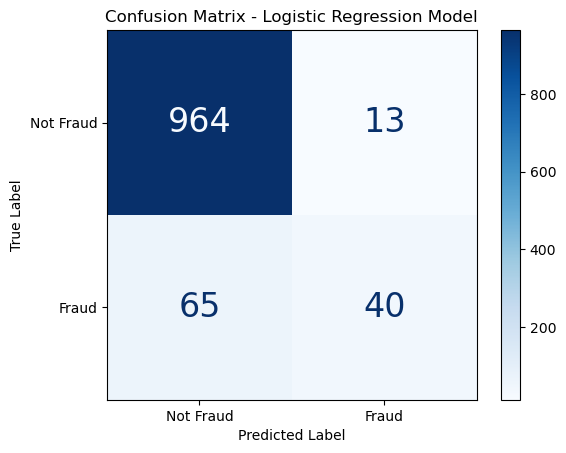

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute and display confusion matrix for Logistic Regression
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 24})
plt.title('Confusion Matrix - Logistic Regression Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

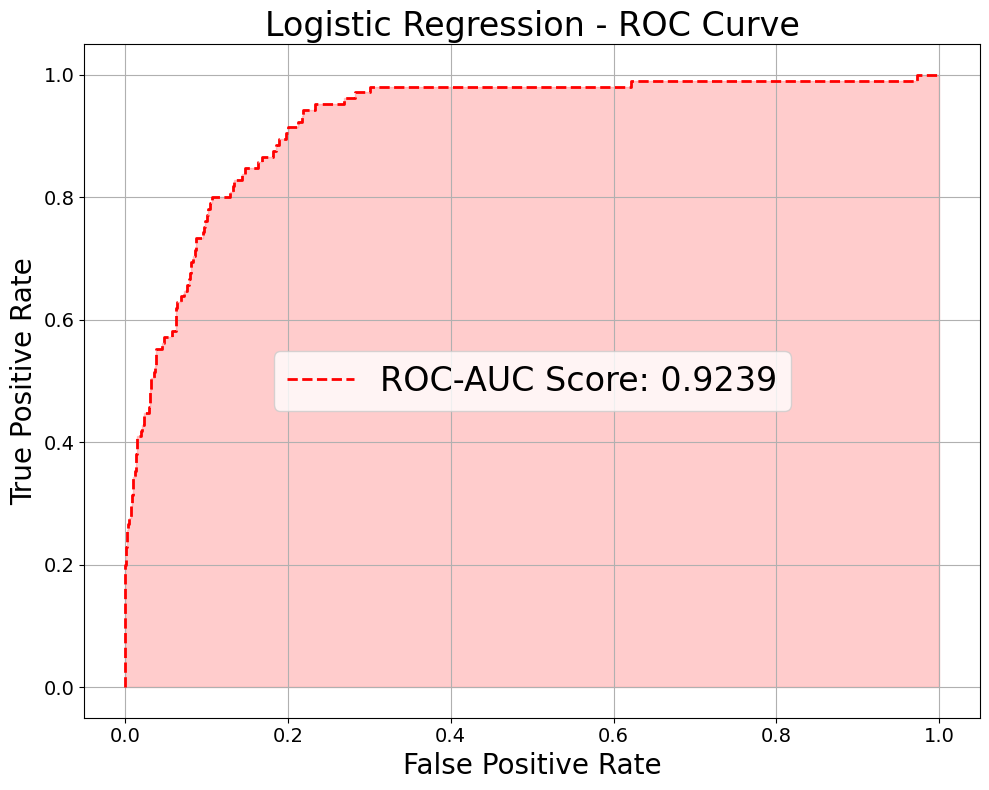

In [33]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'ROC-AUC Score: {roc_auc:.4}')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red')
ax.set_title('Logistic Regression - ROC Curve', fontsize=24)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=24, loc='best')
plt.tight_layout()
ax.grid(True)
plt.show()

In [34]:
from sklearn.metrics import auc
# Area Under Curve for Logistic Regression model.
auc(fpr, tpr)

0.9239362479894722

## Hyperparameter Tuning Using GridSearchCV

- Checking for the best paramters to get the best results for roc-auc "scoring"

In [35]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best roc_auc Score: 0.9390


In [36]:
from sklearn.metrics import classification_report, roc_auc_score

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)


y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC: {roc_auc:.4f}")

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


Test ROC AUC: 0.9257
              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.81      0.28      0.41       105

    accuracy                           0.92      1082
   macro avg       0.87      0.63      0.69      1082
weighted avg       0.92      0.92      0.91      1082



In [37]:
# Compute and display confusion matrix for the best model with GridSearchCV.
cm = confusion_matrix(y_test, y_pred)

print("confusion Matrix after GridSearch only:\n",cm)

confusion Matrix after GridSearch only:
 [[970   7]
 [ 76  29]]


In [38]:
# Flatten again the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) 
print(f'Accuracy: {accuracy:.2f}') # Proportion of correct predictions
precision = TP / (TP + FP) if (TP + FP) != 0 else 0 
print(f'Precision: {precision:.2f}') # Proportion of true positives out of all predicted positives
recall = TP / (TP + FN) if (TP + FN) != 0 else 0 
print(f'Recall: {recall:.2f}') # Proportion of true positives out of all actual positives
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0 
print(f'F1 Score: {f1_score:.2f}') # F1 Score is the harmonic mean of precision and recall

Accuracy: 0.92
Precision: 0.81
Recall: 0.28
F1 Score: 0.41


In [39]:
print(f'Best Logistic Regression Model:\n{best_model}')

Best Logistic Regression Model:
LogisticRegression(C=0.01, max_iter=10000, penalty='l1', solver='liblinear')


## CM and ROC-AUC for GridSearchCV

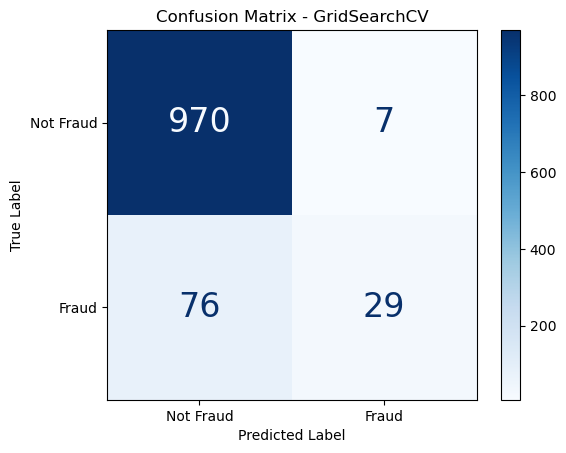

In [40]:
# Compute and display confusion matrix for the best model with GridSearchCV.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 24})
plt.title('Confusion Matrix - GridSearchCV')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

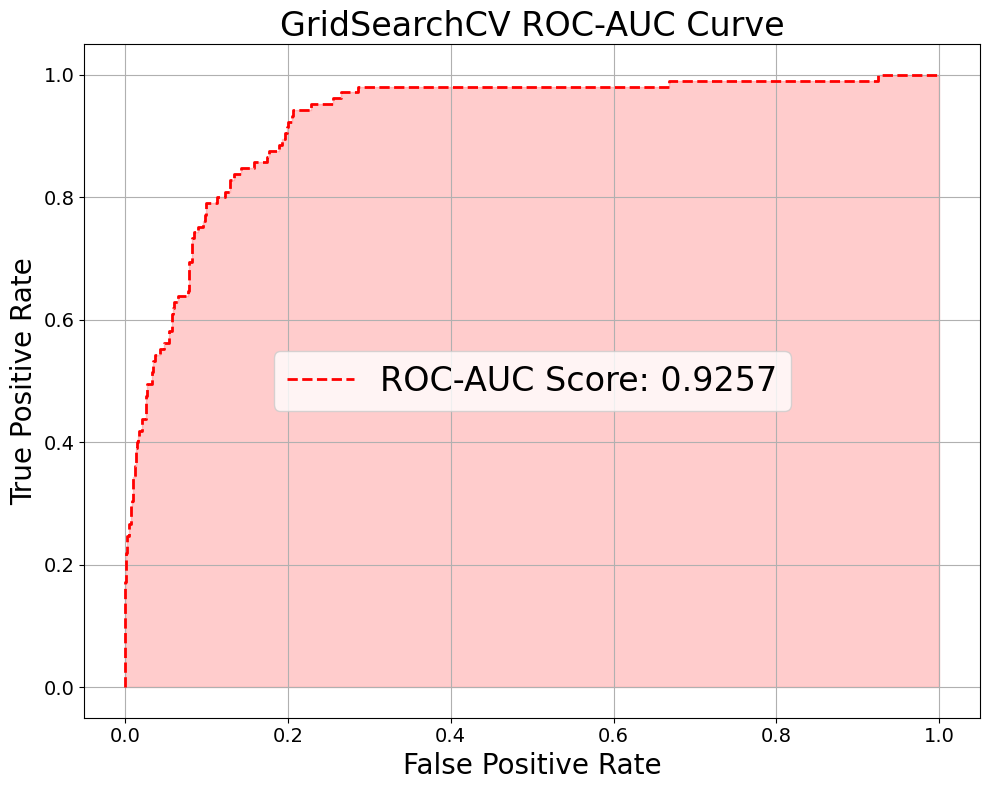

In [41]:
# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=(f'ROC-AUC Score: {roc_auc:.4f}'))
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('GridSearchCV ROC-AUC Curve', fontsize=24)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=24)
plt.tight_layout()
ax.grid(True)
plt.show()

## Logistic Regression with SMOTE

In [42]:
# Print again how the data looks like, before applying a new concept (SMOTE)
final_df.head()

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount,PotentialFraud
0,PRV51001,25.0,5.0,11.0,20.0,0
1,PRV51003,320.0,62.0,165.0,70.0,1
2,PRV51004,0.0,0.0,213.0,149.0,0
3,PRV51005,0.0,0.0,1268.0,1165.0,1
4,PRV51007,16.0,3.0,53.0,69.0,0


In [43]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print(f"Training data size before SMOTE: {y_train.value_counts()}")
print(f"Training data size after SMOTE: {y_train_resampled.value_counts()}")


Training data size before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
Training data size after SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [44]:
# Create and train the Logistic Regression model after SMOTE
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [45]:
from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [46]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[885  96]
 [ 14  87]]


## Confusion Matrix for LR + SMOTE

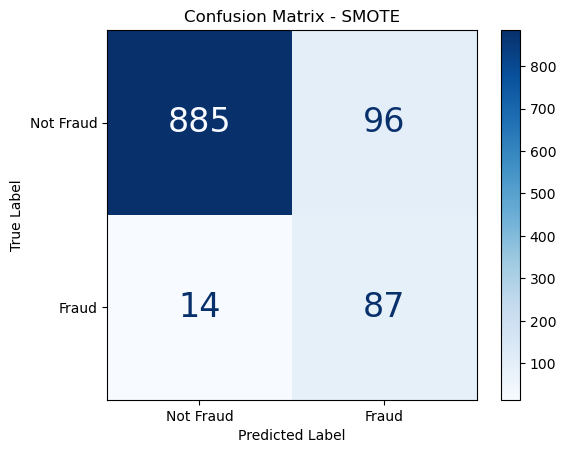

In [47]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 24})
plt.title('Confusion Matrix - SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [48]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.90
Precision: 0.48
Recall: 0.86
F1 Score: 0.61


In [49]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba) 

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9611


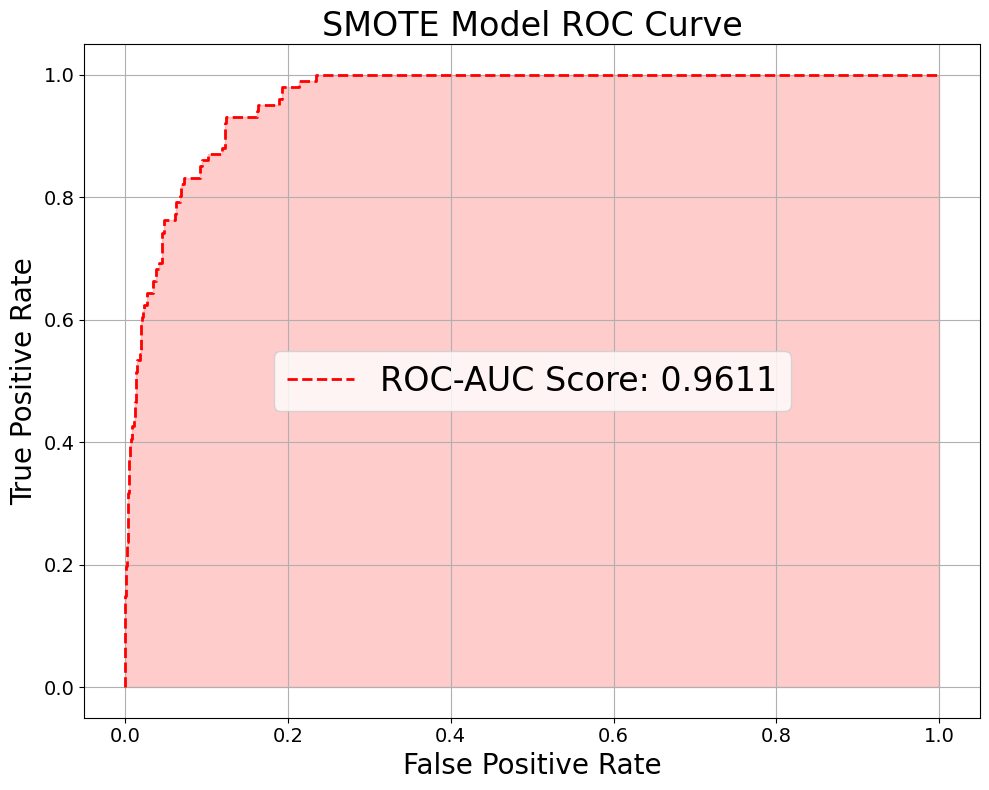

In [50]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'ROC-AUC Score: {roc_auc:.4f}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('SMOTE Model ROC Curve', fontsize=24)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=24, loc='best')
plt.tight_layout()
ax.grid(True)
plt.show()

## Summary

This notebook moves from **provider‑level feature engineering** to a tuned, class‑balanced **Logistic Regression** model for healthcare‑fraud detection.

---

### **Modeling Results**

#### **Logistic Regression (baseline)**
- **Accuracy:** 0.93  
- **Precision:** 0.75  
- **Recall:** 0.38  
- **F1 Score:** 0.51  
- **ROC‑AUC:** 0.9239  
>  *Class imbalance lowers recall.*



#### **Logistic Regression with GridSearchCV**
- **Accuracy:** 0.92  
- **Precision:** 0.81  
- **Recall:** 0.28  
- **F1 Score:** 0.41  
- **ROC‑AUC:** 0.9257  
> *Tuning does not improve the overall scores.*



#### **Logistic Regression with SMOTE**
- **Accuracy:** 0.90  
- **Precision:** 0.48  
- **Recall:** 0.86  
- **F1 Score:** 0.61  
- **ROC‑AUC:** 0.9611  
> *SMOTE boosts recall and delivers the best ROC‑AUC.*

---

## Key Findings
* Longer claim durations may hint at fraud.  
* Manual feature engineering raised model performance.  
* Combining SMOTE with Logistic Regression works well on this imbalanced dataset.
